- In this notebook, I will analyze the statistics of both the total length of the fish in pixels and its actual total length.

## 1) Importing Packages

In [1]:
from ultralytics import YOLO
import cv2
import pandas as pd
import numpy as np
from math import dist
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## -------------------------------------------------------------------------------------------------------------------------------

## 2) Reading the CSV file

In [2]:
data = pd.read_csv("../data/external/size_estimation_homography_DeepFish.csv")
data.head()

,index,file,bbox,class,size (cm)
0,0,26_05_21-B20,"[2272.628996958517, 1685.2591150516498, 837.97...",Sepia officinalis,8.435085
1,1,26_05_21-B25,"[1807.393678506843, 1585.7146585117644, 1094.7...",Mullus barbatus,16.211420
2,2,26_05_21-B25,"[2648.726235342625, 1368.0723135423739, 345.68...",Mullus barbatus,14.422977
3,3,26_05_21-B25,"[2845.1096085383197, 1180.704037335252, 426.91...",Mullus barbatus,15.604945
4,4,26_05_21-B25,"[3192.0335090997633, 1235.4288323372514, 337.1...",Mullus barbatus,14.829357


In [3]:
len(data)

5712

In [4]:
data.iloc[0]["size (cm)"]

8.435085094

In [5]:
eval(data.iloc[0]["bbox"])

[2272.628996958517, 1685.2591150516498, 837.9792848104512, 636.7408849483502]

## -------------------------------------------------------------------------------------------------------------------------------

## 3) Mapping the Pgrus fishes in each image file to their real length

In [6]:
image_file_to_real_length_and_bbox = {}

In [8]:
for i in range(len(data)):
    if data.iloc[i]["class"] != "Pagrus pagrus":
        continue
    image_file = data.iloc[i]["file"]
    real_length = data.iloc[i]["size (cm)"]
    bbox = eval(data.iloc[i]["bbox"])
    try:
        image_file_to_real_length_and_bbox[image_file].append((real_length, bbox))
    except:
        image_file_to_real_length_and_bbox[image_file] = [(real_length, bbox)]

In [9]:
image_file_to_real_length_and_bbox

{'20_05_21-B9': [(20.94685427,
   [728.6062454352258,
    744.1043130836606,
    586.7143651866658,
    1772.0681842833037]),
  (20.94685427,
   [728.6062454352258,
    744.1043130836606,
    586.7143651866658,
    1772.0681842833037])],
 '20_05_21-B27': [(17.34606715,
   [1904.7180879317048, 955, 468.04739210852176, 1472.4938283948868]),
  (16.87775693,
   [588.465458149278,
    799.6410622218417,
    1111.9081544011553,
    1104.4855365480103]),
  (17.34606715,
   [1904.7180879317048, 955, 468.04739210852176, 1472.4938283948868]),
  (16.87775693,
   [588.465458149278,
    799.6410622218417,
    1111.9081544011553,
    1104.4855365480103])],
 '20_05_21-B4': [(28.82235724,
   [624.4841962412784,
    319.6203680669549,
    2069.384106740008,
    883.0123072423005]),
  (24.64772329,
   [1777.8172399133302, 725, 1698.821648941602, 623.6707692311481]),
  (24.4507854,
   [1616.978989689733,
    1193.2704410968674,
    1627.9562196926925,
    1130.4546538540073]),
  (28.82235724,
   [624.484

## -------------------------------------------------------------------------------------------------------------------------------

## 4) Collecting Data for Length in Pixels vs Length in cm

#### Some helper functions

In [10]:
"""This module contains the definition of the _rotatingCaliper function. given n points in the plane, it
first computes the convex hull of the points, then computes the maximum distance between any two points. Total 
runtime is O(nlogn) from the convex hull computation."""
def _absArea(p: np.ndarray, q: np.ndarray, r: np.ndarray) -> float:
    """Calculates tha area of the triangle constructed from 3 input points.

    Args:
        p (np.ndarray): vector of two elements.
        q (np.ndarray): vector of two elements.
        r (np.ndarray): vector of two elements.

    Returns:
        float: area of the triangle.
    """
    return abs(
        (p[0] * q[1] + q[0] * r[1] + r[0] * p[1])
        - (p[1] * q[0] + q[1] * r[0] + r[1] * p[0])
    )


def rotatingCaliper(
    points: np.ndarray,
) -> tuple[float, dict[str, Optional[np.ndarray]]]:
    """Takes as input a two dimensional ndarray where each row is point with a x and a y
    cooradinate and calculates the maximum distance between any two points in the set.
    Complexity is O(nlogn) due to sorting and it returns a tuple of The max_distance
    and a dict which contains the two points that are farthest apart.

    Args:
        points (np.ndarray): set of points to find their max distance.

    Returns:
        tuple[float, dict[str, Optional[np.ndarray]]]: a tuple that contains the maximum distance and
        a dict containing the two points that achieve it.
    """
    pair: dict[str, Optional[np.ndarray]] = {"p1": None, "p2": None}
    if points.shape[0] < 2:
        return 0.0, pair

    hull: np.ndarray = np.squeeze(cv2.convexHull(points))
    n = len(hull)
    

    # Base Cases
    if n == 1:
        raise ValueError
    if n == 2:
        pair["p1"] = hull[0]
        pair["p2"] = hull[1]
        return dist(hull[0], hull[1]), pair
    k = 1

    # Find the farthest vertex
    # from hull[0] and hull[n-1]
    while _absArea(hull[n - 1], hull[0], hull[(k + 1) % n]) > _absArea(
        hull[n - 1], hull[0], hull[k]
    ):
        k += 1

    res = 0.0
    # Check points from 0 to k
    for i in range(k + 1):
        j = (i + 1) % n
        while _absArea(hull[i], hull[(i + 1) % n], hull[(j + 1) % n]) > _absArea(
            hull[i], hull[(i + 1) % n], hull[j]
        ):
            # Update res
            new_dis = dist(hull[i], hull[(j + 1) % n])
            if new_dis > res:
                res = new_dis
                pair["p1"] = hull[i]
                pair["p2"] = hull[(j + 1) % n]
            j = (j + 1) % n
        new_dis = dist(hull[i], hull[j])
        if new_dis > res:
            res = new_dis
            pair["p1"] = hull[i]
            pair["p2"] = hull[j]

    # Return the result distance
    return res, pair


In [11]:
def get_total_length(polygon_points: np.ndarray) -> list[tuple[float, np.ndarray, np.ndarray]]:
    """
    Get the total length in cm and the endpoints of the polygon that has the maximum length.
    The two points are the fish mouth and the end of its tail.
    Args:
        polygon_points (np.ndarray): polygon points of the detected objects in the image.
    Returns:
        list[tuple[float, np.ndarray, np.ndarray]]: list of tuples that contain the total length in cm of the detected object and the endpoints of the polygon as x, y coordinates.
    """
    data = []
    for p in polygon_points:
        total_length, pt_dict = rotatingCaliper(p)
        #total_length = self.transform_total_length_to_cm(total_length)
        p1 = pt_dict["p1"]
        p2 = pt_dict["p2"]
        if p1 is None or p2 is None:
            continue
        data.append((total_length, p1, p2))
    return data

In [12]:
def get_object_polygon_points(results):
    """
    Get the object polygon points as integers which are the masks of the detected objects in the image.
    They are x, y coordinates of the polygon points of the detected objects.
    Args:
        results: results of the segmentation model.
    Returns:
        list[np.ndarray]: list of polygons of detected objects.
    """
    masks = results[0].masks

    # Return an empty list if no objects are detected.
    if masks is None:
        return []

    # get the x, y coordinates of the polygon points of the detected objects.
    polygon_points = masks.xy

    # convert the x, y coordinates to integers.
    polygon_points_int = [array.astype(int) for array in polygon_points]

    return polygon_points_int

In [13]:
def get_boxes_and_length(results):
    bboxes = []
    lengths = []
    for r in results:
        boxes = r.boxes
        for box in boxes:
            bounding_boxes = box.xyxy.cpu().numpy()
            for bounding_box in bounding_boxes:
                bboxes.append(bounding_box)
    polygon_points = get_object_polygon_points(results)
    data = get_total_length(polygon_points)
    for d in data:
        lengths.append(d[0])
    return bboxes, lengths

In [14]:
def check_boxes(box1, box2, thresh=100):
    if( abs(box1[0]-box2[0]) <= thresh and  abs(box1[1]-box2[1]) <= thresh):
        return True
    else:
        return False

#### Load the weights

In [15]:
model = YOLO("../models/best-models/segmentation_model_last.pt")

In [16]:
image_path = "../data/external/all-pagrus-images/7_06_21-B23.jpg"
image = cv2.imread(image_path)

In [17]:
results = model(image)

/home/amro/anaconda3/envs/ai1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0: 480x640 6 pagruss, 79.5ms
Speed: 8.1ms preprocess, 79.5ms inference, 722.7ms postprocess per image at shape (1, 3, 480, 640)


#### Collect the data for the total length in pixels and its correspondig real length

In [18]:
# 1. Run the model on the image that has Pagrus fishes
# 2. Calculate the total length for each fish in pixels
# 3. Add the total length in pixels to the pixels list and its corresponding real length to the real length list

In [19]:
data_dir = "../data/external/all-pagrus-images/" # contains all the images of class Pagrus

In [20]:
def do_job(thresh=100):
    data = [] #contains the pairs ( image_file, bboxes, length in pixels, lengths in cm(real length) )

    for image_file in image_file_to_real_length_and_bbox:
        image_path = data_dir+image_file+".jpg"
        image = cv2.imread(image_path)
        if image.shape != (3024, 4032, 3): # comman shape in the data
            continue
        results = model(image)
        bboxes_model, lengths_pixels = get_boxes_and_length(results)

        items = image_file_to_real_length_and_bbox[image_file]
        for item in items:
            real_length = item[0]
            bbox = item[1]
            for i in range(len(bboxes_model)):
                if check_boxes(bboxes_model[i], bbox, thresh):
                    data.append((image_file, bboxes_model[i], lengths_pixels[i], real_length))
    return data

In [21]:
data = do_job(100)


0: 480x640 8 pagruss, 87.1ms
Speed: 9.4ms preprocess, 87.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 pagruss, 68.0ms
Speed: 2.0ms preprocess, 68.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 75.7ms
Speed: 2.9ms preprocess, 75.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 pagruss, 76.6ms
Speed: 2.3ms preprocess, 76.6ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 pagruss, 66.9ms
Speed: 1.9ms preprocess, 66.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 pagruss, 68.8ms
Speed: 2.1ms preprocess, 68.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 67.8ms
Speed: 2.3ms preprocess, 67.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 67.7ms
Speed: 2.2ms preprocess, 67.7ms inference, 2.1ms postprocess per image at shape (


0: 480x640 7 pagruss, 66.8ms
Speed: 2.0ms preprocess, 66.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 75.0ms
Speed: 2.1ms preprocess, 75.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 72.4ms
Speed: 2.2ms preprocess, 72.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 65.9ms
Speed: 2.5ms preprocess, 65.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 pagruss, 74.5ms
Speed: 3.3ms preprocess, 74.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 65.9ms
Speed: 2.1ms preprocess, 65.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 67.2ms
Speed: 2.3ms preprocess, 67.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 pagruss, 66.6ms
Speed: 2.5ms preprocess, 66.6ms inference, 1.5ms postprocess per image at shape 


0: 480x640 6 pagruss, 68.4ms
Speed: 2.3ms preprocess, 68.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 75.7ms
Speed: 2.2ms preprocess, 75.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 76.2ms
Speed: 2.4ms preprocess, 76.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 66.2ms
Speed: 2.2ms preprocess, 66.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 65.8ms
Speed: 2.3ms preprocess, 65.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 65.6ms
Speed: 2.3ms preprocess, 65.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 66.1ms
Speed: 2.0ms preprocess, 66.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 70.1ms
Speed: 2.6ms preprocess, 70.1ms inference, 1.4ms postprocess per image at shape (

In [22]:
len(data)

780

In [23]:
data2 = do_job(50)


0: 480x640 8 pagruss, 77.1ms
Speed: 2.9ms preprocess, 77.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 pagruss, 75.3ms
Speed: 2.0ms preprocess, 75.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 67.4ms
Speed: 2.3ms preprocess, 67.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 pagruss, 68.6ms
Speed: 2.6ms preprocess, 68.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 pagruss, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 8 pagruss, 67.2ms
Speed: 2.0ms preprocess, 67.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 66.6ms
Speed: 2.2ms preprocess, 66.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 68.2ms
Speed: 2.0ms preprocess, 68.2ms inference, 1.4ms postprocess per image at shape (


0: 480x640 7 pagruss, 68.2ms
Speed: 2.1ms preprocess, 68.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 pagruss, 69.1ms
Speed: 2.2ms preprocess, 69.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 69.3ms
Speed: 2.0ms preprocess, 69.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 67.3ms
Speed: 2.3ms preprocess, 67.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 pagruss, 68.1ms
Speed: 2.0ms preprocess, 68.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 68.4ms
Speed: 2.1ms preprocess, 68.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 77.4ms
Speed: 2.2ms preprocess, 77.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 pagruss, 68.6ms
Speed: 2.1ms preprocess, 68.6ms inference, 1.5ms postprocess per image at shape 


0: 480x640 6 pagruss, 66.8ms
Speed: 2.0ms preprocess, 66.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 67.6ms
Speed: 2.0ms preprocess, 67.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 pagruss, 66.7ms
Speed: 2.1ms preprocess, 66.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 67.7ms
Speed: 2.0ms preprocess, 67.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 67.3ms
Speed: 1.9ms preprocess, 67.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 pagruss, 67.2ms
Speed: 1.9ms preprocess, 67.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 pagruss, 68.2ms
Speed: 2.1ms preprocess, 68.2ms inference, 1.5ms postprocess per image at shape (

In [24]:
len(data2)

764

#### Plot the length in cm vs length in pixels

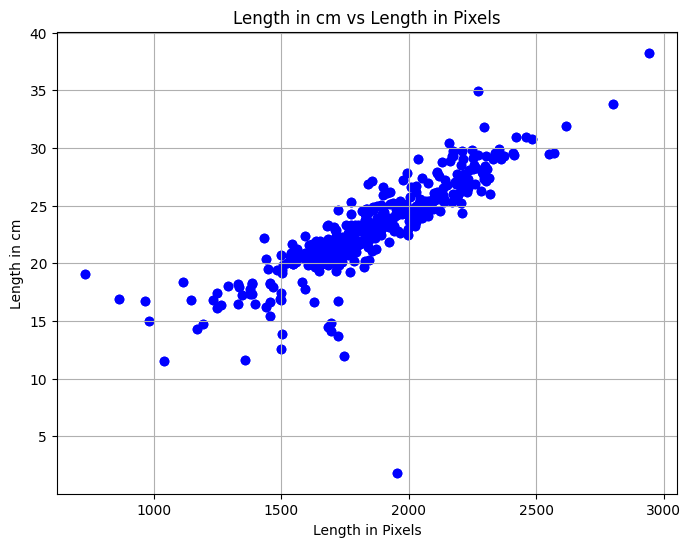

In [52]:
length_in_pixels = [] # contains the total length of the fish in pixels
length_in_cm = []     # contains the total length of the fish in cm (real length)

for d in data:
    length_in_pixels.append(d[2])
    length_in_cm.append(d[3])

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(length_in_pixels, length_in_cm, color='blue', marker='o')

# Add labels and title
plt.xlabel('Length in Pixels')
plt.ylabel('Length in cm')
plt.title('Length in cm vs Length in Pixels')

# Show the plot
plt.grid(True)
plt.show()

#### Plot the distribution

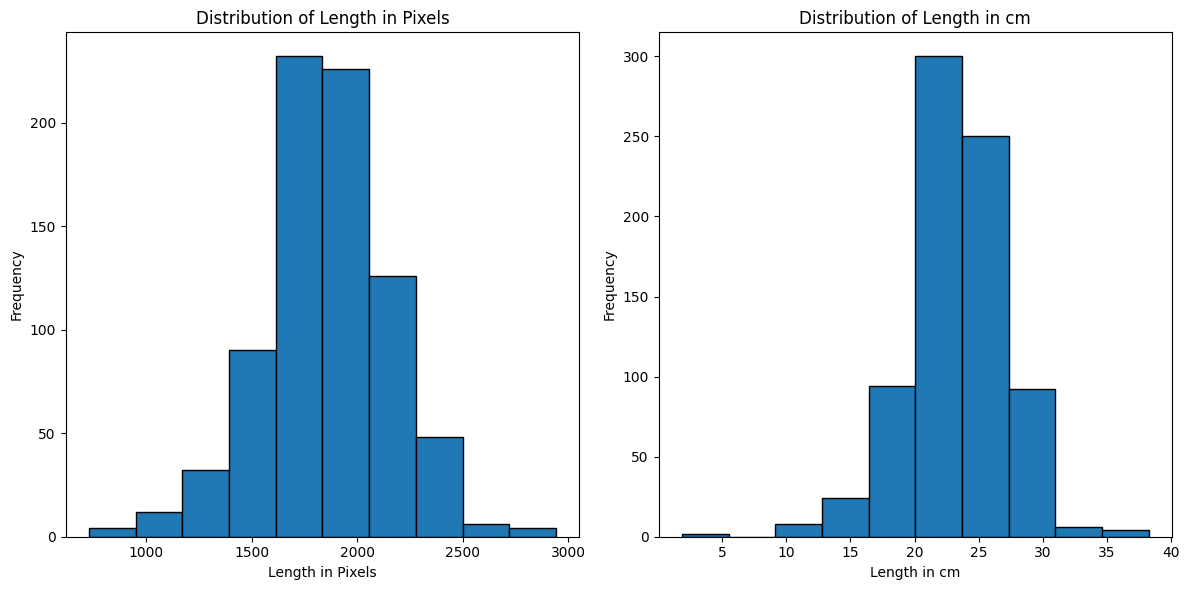

In [53]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of length_in_pixels
axs[0].hist(length_in_pixels, bins=10, edgecolor='black')
axs[0].set_title('Distribution of Length in Pixels')
axs[0].set_xlabel('Length in Pixels')
axs[0].set_ylabel('Frequency')

# Plot distribution of length_in_cm
axs[1].hist(length_in_cm, bins=10, edgecolor='black')
axs[1].set_title('Distribution of Length in cm')
axs[1].set_xlabel('Length in cm')
axs[1].set_ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

## -------------------------------------------------------------------------------------------------------------------------------

## 5) Fitting the Data: (Length in Pixels, Length in cm)

- The input to the model is the length in pixels and the output is the length in cm

#### Split the data into train and test

In [54]:
length_in_pixels = np.array(length_in_pixels)
length_in_cm = np.array(length_in_cm)

# Saving the length in pixels and cm arrays
np.save("../data/length_in_pixels.npy", length_in_pixels)
np.save("../data/length_in_cm.npy", length_in_cm)

# Reshape the data to be compatible with scikit-learn
length_in_pixels = length_in_pixels.reshape(-1, 1)  # Convert to a 2D array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(length_in_pixels, length_in_cm, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (624, 1)
Shape of y_train: (624,)
Shape of X_test: (156, 1)
Shape of y_test: (156,)


#### Simple Linear Regression Model

In [32]:
simple_lr_model = LinearRegression()

In [33]:
simple_lr_model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Get the learned weights (coefficients)
weights = simple_lr_model.coef_
print("w =", weights[0])
# Get the intercept (bias term)
intercept = simple_lr_model.intercept_
print("b =", intercept)

w = 0.011336152434416751
b = 2.0525375542336235


MSE: 3.747894043805012
R2: 0.7593225694755394


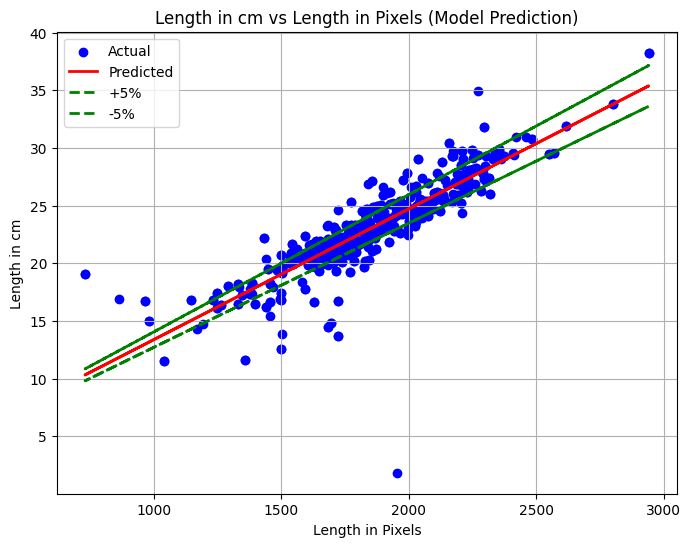

In [43]:
# Evaluate the model on train data
y_pred = simple_lr_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("MSE:", mse)
print("R2:", r2)

# Calculate the 5% greater and smaller lines
y_pred_upper = y_pred * 1.05
y_pred_lower = y_pred * 0.95

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Actual')
plt.plot(X_train, y_pred, color='red', linewidth=2, label='Predicted')
plt.plot(X_train, y_pred_upper, color='green', linestyle='--', linewidth=2, label='+5%')
plt.plot(X_train, y_pred_lower, color='green', linestyle='--', linewidth=2, label='-5%')
plt.xlabel('Length in Pixels')
plt.ylabel('Length in cm')
plt.title('Length in cm vs Length in Pixels (Model Prediction)')
plt.legend()
plt.grid(True)
plt.show()

MSE: 7.259090879858561
R2: 0.579464078578779


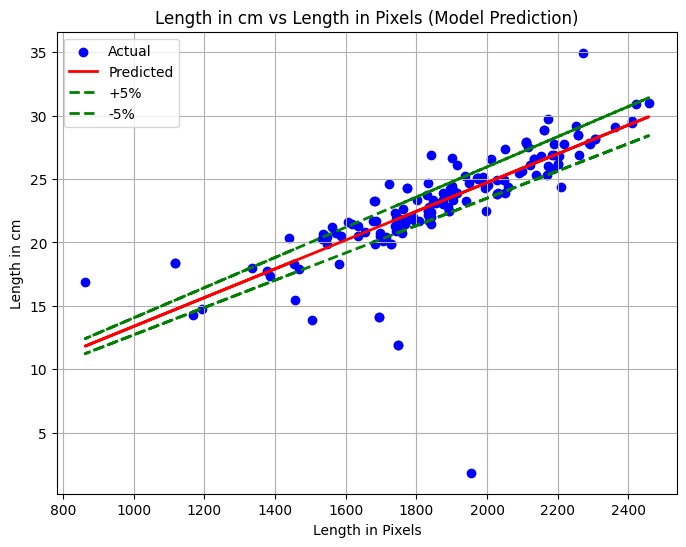

In [44]:
# Evaluate the model on test data
y_pred = simple_lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)

# Calculate the 5% greater and smaller lines
y_pred_upper = y_pred * 1.05
y_pred_lower = y_pred * 0.95

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.plot(X_test, y_pred_upper, color='green', linestyle='--', linewidth=2, label='+5%')
plt.plot(X_test, y_pred_lower, color='green', linestyle='--', linewidth=2, label='-5%')
plt.xlabel('Length in Pixels')
plt.ylabel('Length in cm')
plt.title('Length in cm vs Length in Pixels (Model Prediction)')
plt.legend()
plt.grid(True)
plt.show()

## -------------------------------------------------------------------------------------------------------------------------------

## 6) Another Solution

In [46]:
"""
Another Solution:
- You have a data (length in pixels, length in cm).
- You are given an input x which is length in pixels.
- Search for the nearest k values to x in the data and then average the length in cm corresponding to each value, 
  and this is the output.
** If the input image is scaled, we can resize to (3024, 4032, 3), which is the common shape in the data.
** The pilot should make sure that the image on the banner fits the entire frame.

Shapes found in the dataset of Pagrus images:
(3024, 4032, 3): 184 images
(2736, 3648, 3): 26 images
(3648, 2736, 3): 1 image
(2448, 3264, 3): 1 image
"""

In [47]:
def knn(x,k):  
    # Calculate the absolute difference between x and each length in pixels
    differences = np.abs(length_in_pixels - x)
    
    nearest_neighbors = []
    
    # Iterate over the differences and their indices
    for i, diff in enumerate(differences):
        # If we have less than k neighbors, add the current one
        if len(nearest_neighbors) < k:
            nearest_neighbors.append((diff, length_in_cm[i]))
            nearest_neighbors.sort()  # Keep the list sorted
        else:
            # Check if the current neighbor is closer than the farthest in the list
            if diff < nearest_neighbors[-1][0]:
                nearest_neighbors[-1] = (diff, length_in_cm[i])
                nearest_neighbors.sort()  # Keep the list sorted

    # Extract the lengths in cm from the nearest neighbors
    nearest_lengths_cm = [length for _, length in nearest_neighbors]
    
    # Compute the average of these lengths in cm
    average_length_cm = np.mean(nearest_lengths_cm)

    return average_length_cm

MSE: 1.3584987417808567
R2: 0.9127616782328813


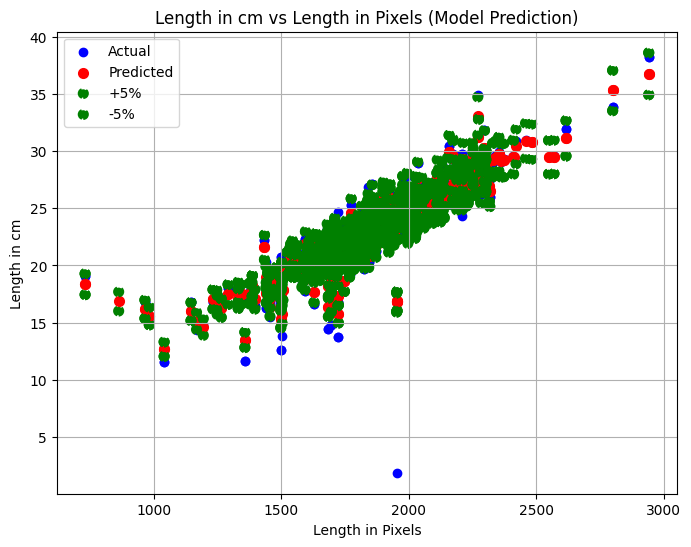

In [48]:
# Evaluate on train data
k = 3
y_pred = []
for x in X_train:
    y = knn(x[0],k)
    y_pred.append(y)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("MSE:", mse)
print("R2:", r2)

# Calculate the 5% greater and smaller lines
y_pred_upper = y_pred * 1.05
y_pred_lower = y_pred * 0.95

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Actual')
plt.scatter(X_train, y_pred, color='red', linewidth=2, label='Predicted')

plt.scatter(X_train, y_pred_upper, color='green', linestyle='--', linewidth=2, label='+5%')
plt.scatter(X_train, y_pred_lower, color='green', linestyle='--', linewidth=2, label='-5%')

plt.xlabel('Length in Pixels')
plt.ylabel('Length in cm')
plt.title('Length in cm vs Length in Pixels (Model Prediction)')
plt.legend()
plt.grid(True)
plt.show()

MSE: 2.0897653653566524
R2: 0.8789350597727277


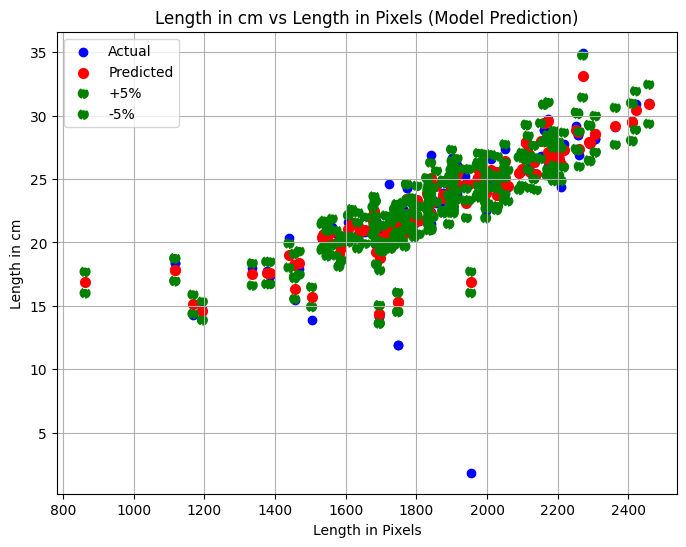

In [49]:
# Evaluate on test data
k = 3
y_pred = []
for x in X_test:
    y = knn(x[0],k)
    y_pred.append(y)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)

# Calculate the 5% greater and smaller lines
y_pred_upper = y_pred * 1.05
y_pred_lower = y_pred * 0.95

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', linewidth=2, label='Predicted')

plt.scatter(X_test, y_pred_upper, color='green', linestyle='--', linewidth=2, label='+5%')
plt.scatter(X_test, y_pred_lower, color='green', linestyle='--', linewidth=2, label='-5%')

plt.xlabel('Length in Pixels')
plt.ylabel('Length in cm')
plt.title('Length in cm vs Length in Pixels (Model Prediction)')
plt.legend()
plt.grid(True)
plt.show()

In [131]:
image.shape

(2736, 3648, 3)

In [132]:
img = cv2.resize(image, (4032, 3024), interpolation=cv2.INTER_LINEAR)
img.shape == (3024, 4032, 3

True

In [128]:
img.shape

(3024, 4032, 3)

In [124]:
#plt.imshow(image)

In [50]:
length_in_pixels.shape

(780, 1)

In [51]:
length_in_cm.shape

(780,)